<a href="https://colab.research.google.com/github/Nikhil-4-Pal/INSA-Project---Siamese-MobileViT-based-change-detection-for-Disaster-Damage-Estimation/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print('the torch version is : ',torch.__version__)
print('GPU name : ', torch.cuda.get_device_name()) if torch.cuda.is_available() else print('GPU is not available')

the torch version is :  2.2.2+cu118
GPU name :  NVIDIA RTX A4000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device Using : ",device , torch.cuda.get_device_name())

Device Using :  cuda NVIDIA RTX A4000


In [ ]:
import gc
import torch

# After the epoch loop of each stage
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
!pip install raft-pytorch

ERROR: Could not find a version that satisfies the requirement raft-pytorch (from versions: none)
ERROR: No matching distribution found for raft-pytorch


In [ ]:
!pip install scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import torch
import logging
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Optional, Tuple
import torch.nn.functional as F
from torchvision.models.optical_flow import raft_large
import torch
from torch.utils.data import DataLoader
import numpy as np
from typing import List, Tuple, Optional, Dict, Any
import logging
import torch.nn as nn
import timm
from timm import create_model
import math
from typing import Optional, Tuple, Union
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import warnings
import time
from collections import defaultdict


C:\Users\USER\colab-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Class

In [ ]:
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
import torch.nn.functional as F

# Load RAFT model globally (once)
_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_raft_weights = Raft_Small_Weights.DEFAULT
_raft_model = raft_small(weights=_raft_weights).to(_device).eval()

def warp_post_with_raft(pre_img: np.ndarray, post_img: np.ndarray, target_size=(512, 512)) -> np.ndarray:


    # Resize both images to target size for RAFT
    pre_resized = cv2.resize(pre_img, target_size, interpolation=cv2.INTER_LINEAR)
    post_resized = cv2.resize(post_img, target_size, interpolation=cv2.INTER_LINEAR)

    # Convert to tensor, normalize to [0, 1], shape (1, 3, H, W)
    pre_tensor = TF.to_tensor(pre_resized).unsqueeze(0).to(_device)
    post_tensor = TF.to_tensor(post_resized).unsqueeze(0).to(_device)

    with torch.no_grad():
        # Get flow from pre → post
        flow_predictions = _raft_model(pre_tensor, post_tensor)  # This returns a list
        flow = flow_predictions[-1]

        # Build normalized grid for warping
        N, C, H, W = flow.shape
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).float().to(_device)  # (2, H, W)
        grid = grid.unsqueeze(0)  # (1, 2, H, W)
        new_coords = grid + flow  # (1, 2, H, W)

        # Normalize to [-1, 1] for grid_sample
        new_coords[:, 0] = 2.0 * new_coords[:, 0] / (W - 1) - 1.0
        new_coords[:, 1] = 2.0 * new_coords[:, 1] / (H - 1) - 1.0
        new_coords = new_coords.permute(0, 2, 3, 1)  # (1, H, W, 2)

        # Warp post image
        warped_post = F.grid_sample(post_tensor, new_coords, mode='bilinear', padding_mode='border', align_corners=True)

    # Convert warped image back to numpy
    warped_post_np = warped_post.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (H, W, 3)
    warped_post_np = (warped_post_np * 255.0).clip(0, 255).astype(np.uint8)

    return warped_post_np


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Optional, Callable

class xBDDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 mode: str = 'test',
                 transform: Optional[Callable] = None,
                 use_raft: bool = False,
                 raft_align_fn: Optional[Callable] = None,
                 raft_target_size: Tuple[int, int] = (512, 512)): # Added raft_target_size

        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transform = transform
        self.use_raft = use_raft
        self.raft_align_fn = raft_align_fn
        self.raft_target_size = raft_target_size # Store raft target size

        # List of image base names (without pre/post suffix)
        all_files = os.listdir(self.image_dir)
        self.sample_ids = sorted(set([
            "_".join(f.split("_")[:-2])
            for f in all_files if f.endswith("pre_disaster.png")
        ]))

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
      sample_id = self.sample_ids[idx]

      try:
          # Construct full filenames
          pre_path = os.path.join(self.image_dir, f"{sample_id}_pre_disaster.png")
          post_path = os.path.join(self.image_dir, f"{sample_id}_post_disaster.png")
          mask_path = os.path.join(self.mask_dir, f"{sample_id}_post_disaster_rgb.png")

          # Load images
          pre = cv2.imread(pre_path, cv2.IMREAD_COLOR)
          post = cv2.imread(post_path, cv2.IMREAD_COLOR)
          mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

          if pre is None or post is None or mask is None:
              raise RuntimeError(f"Corrupt image or missing file: {sample_id}")

          # BGR to RGB
          pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
          post = cv2.cvtColor(post, cv2.COLOR_BGR2RGB)
          mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

          # RAFT alignment
          if self.use_raft and self.raft_align_fn is not None:
              post = self.raft_align_fn(pre.copy(), post.copy(), target_size=self.raft_target_size)
              pre = cv2.resize(pre, self.raft_target_size, interpolation=cv2.INTER_LINEAR)
              mask = cv2.resize(mask, self.raft_target_size, interpolation=cv2.INTER_NEAREST)

          # Albumentations transform
          if self.transform:
              augmented = self.transform(image=pre, image0=post, mask=mask)
          else:
              transform = A.Compose([
                  A.Resize(256, 256),
                  A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                  ToTensorV2()
              ], additional_targets={"image0": "image", "mask": "mask"})
              augmented = transform(image=pre, image0=post, mask=mask)

          pre = augmented["image"]
          post = augmented["image0"]
          mask = augmented["mask"]

          # Convert RGB mask to label
          mask = self.rgb_to_class(mask.permute(2, 0, 1))

          return pre, post, mask

      except Exception as e:
          print(f"⚠️ Error loading sample {sample_id}: {e}")
          # Try next sample
          new_idx = (idx + 1) % len(self)
          return self.__getitem__(new_idx)


    def rgb_to_class(self, mask: torch.Tensor) -> torch.Tensor:
      color_map = {
          (255, 255, 255): 0,  # no damage
          (0, 255, 0): 1,      # minor damage
          (255, 255, 0): 2,    # major damage
          (255, 0, 0): 3       # destroyed
      }

      # Ensure correct shape and type: expects [3, H, W]
      if mask.shape[0] != 3:
          raise ValueError(f"Mask shape invalid: expected [3,H,W], got {mask.shape}")

      h, w = mask.shape[1], mask.shape[2]
      label_mask = torch.zeros((h, w), dtype=torch.long)

      # Iterate through color map and apply masks
      for rgb, cls in color_map.items():
          r, g, b = rgb
          # Create a boolean mask for pixels matching the current color
          match = (mask[0] == r) & (mask[1] == g) & (mask[2] == b)
          # Assign the class label to matching pixels
          label_mask[match] = cls

      return label_mask

In [ ]:
transformONE = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
    ToTensorV2()
], additional_targets={"image0": "image" , "mask":"mask"})

In [ ]:
# For my PC
"""
dataset = xBDDataset(
    root_dir = r"/content/drive/MyDrive/xBD_Dataset/smalltrain",
    transform=transformONE ,# Use train_transform instead of transform
    use_raft=True,
    raft_align_fn=warp_post_with_raft
)

pre , post ,mask = dataset[0]
print(pre.shape, post.shape, mask.shape)
"""

torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])


In [ ]:

dataset = xBDDataset(
    root_dir = r"C:\Users\USER\Desktop\INSA\xBD_Dataset\xBD_Dataset\xbd\tier3",
    transform=transformONE ,# Use train_transform instead of transform
    use_raft=True,
    raft_align_fn=warp_post_with_raft
)

pre , post ,mask = dataset[0]
print(pre.shape, post.shape, mask.shape)


torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])


In [ ]:
print("Pre dtype:", pre.dtype)     # torch.float32
print("Post dtype:", post.dtype)   # torch.float32
print("Mask dtype:", mask.dtype)   # torch.int64 (after rgb_to_class)


Pre dtype: torch.float32
Post dtype: torch.float32
Mask dtype: torch.int64


In [ ]:
from torch.utils.data import random_split

from torch.utils.data import DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
# to use with cpu only
"""
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
"""

'\ntrain_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)\nval_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)\n'

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True , num_workers= 0 )
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False , num_workers= 0 )

In [ ]:
import torch
import torch.nn as nn
import timm


class MobileViTEncoder(nn.Module):
    def __init__(self, backbone_name='mobilevit_s', pretrained=True, output_stride=16, freeze_backbone=False):
        super().__init__()

        self.backbone_name = backbone_name
        self.model = timm.create_model(backbone_name, features_only=True, pretrained=pretrained, out_indices=(0, 1, 2, 3))

        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False

        self.feature_channels = [f['num_chs'] for f in self.model.feature_info]

    def forward(self, x):
        # Returns list of feature maps
        features = self.model(x)
        return features


In [ ]:
encoder = MobileViTEncoder('mobilevit_s', pretrained=True)
x = torch.randn(1, 3, 512, 512)
features = encoder(x)
for i, feat in enumerate(features):
    print(f"Feature {i}: {feat.shape}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Feature 0: torch.Size([1, 32, 256, 256])
Feature 1: torch.Size([1, 64, 128, 128])
Feature 2: torch.Size([1, 96, 64, 64])
Feature 3: torch.Size([1, 128, 32, 32])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)


class EnhancedMultiScaleFusion(nn.Module):
    def __init__(self, channels, fusion_type='concat_absdiff', total_out_channels=1024, use_attention=True, normalize_features=False):
        super().__init__()
        self.channels = channels
        self.fusion_type = fusion_type
        self.use_attention = use_attention
        self.normalize_features = normalize_features
        self.target_size = None

        # Dynamically compute expected output channels based on fusion strategy
        if fusion_type == 'concat':
            self.raw_out_channels = sum([2 * c for c in channels])
        elif fusion_type == 'add':
            self.raw_out_channels = sum(channels)
        elif fusion_type == 'concat_absdiff':
            self.raw_out_channels = sum([3 * c for c in channels])  # pre + post + |pre - post|
        else:
            raise ValueError(f"Unsupported fusion type: {fusion_type}")

        # Channel attention blocks for pre + post features
        if self.use_attention:
            self.att_blocks = nn.ModuleList([
                ChannelAttention(c) for c in channels + channels
            ])

        # Final projection to fixed fusion output channels
        self.proj = nn.Conv2d(self.raw_out_channels, total_out_channels, kernel_size=1)
        self.total_out_channels = total_out_channels  # Used by decoder

    def forward(self, pre_feats, post_feats):
        fused_feats = []
        self.target_size = pre_feats[-1].shape[2:]  # use smallest resolution

        for i, (pre_f, post_f) in enumerate(zip(pre_feats, post_feats)):
            # Upsample to common size
            pre_f = F.interpolate(pre_f, size=self.target_size, mode='bilinear', align_corners=False)
            post_f = F.interpolate(post_f, size=self.target_size, mode='bilinear', align_corners=False)

            # Attention
            if self.use_attention:
                pre_f = self.att_blocks[i](pre_f)
                post_f = self.att_blocks[i + len(pre_feats)](post_f)

            # Normalize features
            if self.normalize_features:
                pre_f = F.normalize(pre_f, p=2, dim=1)
                post_f = F.normalize(post_f, p=2, dim=1)

            # Fusion strategy
            if self.fusion_type == 'concat':
                fused = torch.cat([pre_f, post_f], dim=1)
            elif self.fusion_type == 'add':
                fused = pre_f + post_f
            elif self.fusion_type == 'concat_absdiff':
                diff = torch.abs(pre_f - post_f)
                fused = torch.cat([pre_f, post_f, diff], dim=1)
            else:
                raise ValueError(f"Unsupported fusion_type: {self.fusion_type}")

            fused_feats.append(fused)

        # Concatenate across all fused scales
        fused_output = torch.cat(fused_feats, dim=1)  # shape: (B, raw_out_channels, H, W)

        # Project to fixed channel size (e.g., 1024)
        fused_output = self.proj(fused_output)

        return fused_output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise average and max pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        # Concatenate and convolve
        concat = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]
        attn_map = self.sigmoid(self.conv(concat))     # [B, 1, H, W]

        return x * attn_map


In [ ]:
class EnhancedFinalDecoder(nn.Module):
    def __init__(self, fusion_channels=1024, num_classes=4,
                 skip_channels=[96, 64, 32],  # must match encoder's skip outputs
                 use_attention=True,
                 deep_supervision=True,
                 dropout_rate=0.1):
        super().__init__()

        self.deep_supervision = deep_supervision
        self.use_attention = use_attention

        # Decoder blocks now include skip connection channel sizes
        self.block1 = self._make_block(fusion_channels, 512)                      # Input: fusion only
        self.block2 = self._make_block(512 + skip_channels[0], 256)              # + skip 1 (96)
        self.block3 = self._make_block(256 + skip_channels[1], 128)              # + skip 2 (64)
        self.block4 = self._make_block(128 + skip_channels[2], 64)               # + skip 3 (32)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        if deep_supervision:
            self.aux1 = nn.Conv2d(256, num_classes, kernel_size=1)
            self.aux2 = nn.Conv2d(128, num_classes, kernel_size=1)

        self.dropout = nn.Dropout2d(p=dropout_rate)

    def _make_block(self, in_c, out_c):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        ]
        if self.use_attention:
            layers.append(ChannelAttention(out_c))
            layers.append(SpatialAttention())
        return nn.Sequential(*layers)

    def forward(self, x, target_size, skip_features=None):

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # → 32x32
        x = self.block1(x)  # [B, 512, 32, 32]

        if skip_features is not None:
            x = torch.cat([x, skip_features[0]], dim=1)  # + skip1 (96)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # → 64x64
        x = self.block2(x)
        aux1_out = self.aux1(x) if self.deep_supervision else None

        if skip_features is not None:
            x = torch.cat([x, skip_features[1]], dim=1)  # + skip2 (64)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # → 128x128
        x = self.block3(x)
        aux2_out = self.aux2(x) if self.deep_supervision else None

        if skip_features is not None:
            x = torch.cat([x, skip_features[2]], dim=1)  # + skip3 (32)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # → 256x256
        x = self.block4(x)

        x = self.dropout(x)

        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)  # final resize
        out = self.final(x)

        if self.deep_supervision:
            aux1_out = F.interpolate(aux1_out, size=target_size, mode='bilinear', align_corners=False)
            aux2_out = F.interpolate(aux2_out, size=target_size, mode='bilinear', align_corners=False)
            return out, [aux1_out, aux2_out]

        return out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.softmax(outputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=outputs.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        TP = (outputs * targets_one_hot).sum(dim=(2, 3))
        FP = (outputs * (1 - targets_one_hot)).sum(dim=(2, 3))
        FN = ((1 - outputs) * targets_one_hot).sum(dim=(2, 3))

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1.0 - tversky.mean()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=1.0, tversky_weight=1.0):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.tversky = TverskyLoss()
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight

    def forward(self, outputs, targets):
        if isinstance(outputs, tuple):
            main_output = outputs[0]
        else:
            main_output = outputs

        ce_loss = self.ce(main_output, targets)
        tversky_loss = self.tversky(main_output, targets)

        return self.ce_weight * ce_loss + self.tversky_weight * tversky_loss





In [ ]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, aux_weights=[0.4, 0.2]):
        super().__init__()
        self.base_loss = CombinedLoss()
        self.aux_weights = aux_weights

    def forward(self, output, target):

        if not isinstance(output, tuple):
            return self.base_loss(output, target)

        main_pred, aux_preds = output
        total_loss = self.base_loss(main_pred, target)

        for aux_pred, weight in zip(aux_preds, self.aux_weights):
            total_loss += weight * self.base_loss(aux_pred, target)

        return total_loss


In [ ]:
def compute_iou(preds: torch.Tensor, labels: torch.Tensor, num_classes: int = 4):
    with torch.no_grad():
        # If preds is a tuple (main_output, aux_outputs), take main
        if isinstance(preds, tuple):
            preds = preds[0]

        preds = torch.argmax(preds, dim=1)  # (B, H, W)
        ious = []

        for cls in range(num_classes):
            pred_inds = (preds == cls)
            target_inds = (labels == cls)
            intersection = (pred_inds & target_inds).float().sum()
            union = (pred_inds | target_inds).float().sum()

            # Safe IoU calculation
            if union == 0:
                iou = 1.0  # If class absent in both, perfect
            else:
                iou = intersection / union

            ious.append(float(iou))  # ← use float() instead of .item()

        return sum(ious) / len(ious)


In [ ]:
from sklearn.metrics import confusion_matrix
def compute_metrics(preds: torch.Tensor, labels: torch.Tensor, num_classes: int = 4, class_names=None):
    with torch.no_grad():
        preds = torch.argmax(preds, dim=1)  # (B, H, W)

        # Flatten
        preds_flat = preds.view(-1).cpu().numpy()
        labels_flat = labels.view(-1).cpu().numpy()

        # Pixel Accuracy
        pixel_accuracy = (preds_flat == labels_flat).sum() / len(labels_flat)

        # Confusion Matrix
        cm = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))

        # Per-Class IoU and F1
        ious, f1s = [], []
        for cls in range(num_classes):
            TP = cm[cls, cls]
            FP = cm[:, cls].sum() - TP
            FN = cm[cls, :].sum() - TP
            denom = TP + FP + FN

            iou = TP / denom if denom > 0 else 1.0
            f1 = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0

            ious.append(iou)
            f1s.append(f1)

        # Print nicely if class_names are provided
        if class_names:
            print("\n📌 Per-Class Metrics:")
            for i in range(num_classes):
                print(f"  {class_names[i]:12s} | IoU: {ious[i]:.4f} | F1: {f1s[i]:.4f}")

        return {
            'pixel_accuracy': pixel_accuracy,
            'mean_iou': np.mean(ious),
            'per_class_iou': ious,
            'macro_f1': np.mean(f1s),
            'confusion_matrix': cm
        }


In [ ]:
def get_transform(stage="small"):
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    size_map = {"small": 256, "medium": 512, "large": 1024}
    size = size_map[stage]

    return A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.CLAHE(p=0.2),
        A.HueSaturationValue(p=0.2),
        A.GridDistortion(p=0.2),
        A.GaussianBlur(p=0.2),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ], additional_targets={"image0": "image"})


In [ ]:
from torch.optim import lr_scheduler , Adam
def progressive_train(
    model, dataset, device,
    stages=("small", "medium","large"),
    stage_epochs=(20, 20,20),
    batch_sizes=(8,8,4),
    lr=1e-3,
    save_path="best_model.pth",
    visualize_every = 5
):
    import torch.optim as optim
    from torch.utils.data import DataLoader
    from copy import deepcopy

    all_train_losses, all_val_losses = [], []
    all_train_matrics, all_val_matrics = [], []

    best_iou = 0
    model = model.to(device)

    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for stage_idx, stage in enumerate(stages):
        print(f"\n🔁 Starting Stage: {stage.upper()} | {stage_epochs[stage_idx]} epochs")

        # Set transform
        dataset.transform = get_transform(stage)

        # Reload dataset & dataloader
        train_loader = DataLoader(dataset, batch_size=batch_sizes[stage_idx], shuffle=True, num_workers=0)

        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

        for epoch in range(stage_epochs[stage_idx]):
            model.train()
            train_loss, train_matrics = train_one_epoch(model, train_loader,optimizer=optimizer, criterion = criterion, device = device)
            val_loss, val_matrics = validate_one_epoch(model, train_loader, criterion = criterion, device = device)

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)
            all_train_matrics.append(list(train_matrics.values()))
            all_val_matrics.append(list(val_matrics.values()))

            train_matrics = all_train_matrics[-1]
            val_matrics = all_val_matrics[-1]

            print(f"[Stage {stage} | Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Pixel Accuracy: {train_matrics[0]:.4f} , Train mean IoU : {train_matrics[1]:.4f} , Train Per Class IoU : {all_train_matrics[-1][2]} , Train Macro F1 : {train_matrics[3]:.4f} , Train Confusion Matrix : {all_train_matrics[-1][4]} | Val Loss: {val_loss:.4f}, Val Pixel Accuracy : {val_matrics[0]:.4f} , Val mean IoU : {val_matrics[1]:.4f} , Val Per Class IoU : {all_val_matrics[-1][2]} , Val Macro F1 : {val_matrics[3]:.4f} , Val Confusion Matrix : {all_val_matrics[-1][4]}")

            scheduler.step(epoch + stage_idx * stage_epochs[stage_idx])

            if all_val_matrics[epoch][1] > best_iou:
                best_iou = all_val_matrics[epoch][1]
                print("✅ Saving improved model")
                torch.save({
                    "model_state_dict": deepcopy(model.state_dict()),
                    "best_iou": best_iou
                }, save_path)

            if visualize_every and (epoch + 1) % visualize_every == 0:
              visualize_predictions(model, dataset, device=device, num_samples=3)

    print(f"\n🎯 Training Done | Best IoU: {best_iou:.4f}")
    return {
        "train_losses": all_train_losses,
        "val_losses": all_val_losses,
        "train_ious": all_train_matrics,
        "val_ious": all_val_matrics,
        "best_iou": best_iou
    }


In [ ]:
import torch
import torch.nn as nn

class ChangeDetectionModel(nn.Module):
    def __init__(self,
                 backbone='mobilevit_s',
                 num_classes=4,
                 fusion_type='concat_absdiff',
                 use_attention=True,
                 deep_supervision=False,
                 pretrained=True):
        super().__init__()

        # ✅ Siamese MobileViT encoder
        self.encoder = MobileViTEncoder(
            backbone_name=backbone,
            pretrained=pretrained,
            freeze_backbone=False
        )

        # ✅ Multi-scale fusion
        self.fusion = EnhancedMultiScaleFusion(
            #channels=self.encoder.feature_channels,
            channels=[32,64,96,128],
            fusion_type=fusion_type,
            use_attention=use_attention,
            normalize_features=True
        )

        # ✅ Decoder (with or without deep supervision)
        if deep_supervision:
            self.decoder = EnhancedFinalDecoder(
                fusion_channels=self.fusion.total_out_channels,
                num_classes=num_classes,
                use_attention=True,
                deep_supervision=True
            )
        else:
            self.decoder = EnhancedFinalDecoder(
                fusion_channels=self.fusion.total_out_channels,
                num_classes=num_classes,
                use_attention=True
            )

        self.num_classes = num_classes
        self.deep_supervision = deep_supervision

    def forward(self, pre_img, post_img):
        # Each image: [B, 3, H, W]
        print("Running encoder...")
        # ➤ Siamese encoding
        pre_feats = self.encoder(pre_img)    # List of [B, C_i, H_i, W_i]
        post_feats = self.encoder(post_img)
        print("Encoder done")

        print("Running fusion...\n")
        # ➤ Fusion
        skip_feats = [  # pick mid-resolution features
            (pre_feats[2] + post_feats[2]) / 2,
            (pre_feats[1] + post_feats[1]) / 2,
            (pre_feats[0] + post_feats[0]) / 2
        ]

        fused = self.fusion(pre_feats, post_feats)
        logits = self.decoder(fused, pre_img.shape[2:], skip_feats)
        return logits


In [ ]:
def create_change_detection_model(config: dict) -> ChangeDetectionModel:
    return ChangeDetectionModel(
        backbone=config.get('backbone', 'mobilevit_s'),
        num_classes=config.get('num_classes', 4),
        fusion_type=config.get('fusion_type', 'cosine'),
        use_attention=config.get('use_attention', True),
        deep_supervision=config.get('deep_supervision', False),
        pretrained=config.get('pretrained', True)
    )


In [ ]:
if __name__ == "__main__":
    config = {
        'backbone': 'mobilevit_s',
        'num_classes': 4,
        'fusion_type': 'concat_absdiff',
        'use_attention': True,
        'deep_supervision': False,
        'pretrained': True
    }

    model = create_change_detection_model(config)

    # Dummy test input
    pre = torch.randn(2, 3, 512, 512)
    post = torch.randn(2, 3, 512, 512)

    output = model(pre, post)

    if isinstance(output, tuple):
        print("Main output:", output[0].shape)
        print("Aux outputs:", len(output[1]))
    else:
        print("Output:", output.shape)


Running encoder...
Encoder done
Running fusion...
Main output: torch.Size([2, 4, 512, 512])
Aux outputs: 2


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataset, device='cuda', num_samples=5, class_names=None):
    model.eval()
    plt.figure(figsize=(12, num_samples * 3))

    for idx in range(num_samples):
        pre, post, gt_mask = dataset[idx]

        # Move to device and add batch dimension
        pre_input = pre.unsqueeze(0).to(device)
        post_input = post.unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            preds = model(pre_input, post_input)
            if isinstance(preds, tuple):
                preds = preds[0]  # for deep supervision case

        pred_mask = torch.argmax(preds, dim=1).squeeze().cpu().numpy()  # shape: (H, W)
        gt_mask = gt_mask.cpu().numpy()  # shape: (H, W)

        # Convert tensors to numpy images
        pre_img = pre.permute(1, 2, 0).cpu().numpy()
        post_img = post.permute(1, 2, 0).cpu().numpy()

        # Undo normalization if needed
        pre_img = (pre_img * 0.5 + 0.5).clip(0, 1)
        post_img = (post_img * 0.5 + 0.5).clip(0, 1)

        # Plot
        plt.subplot(num_samples, 4, idx * 4 + 1)
        plt.imshow(pre_img)
        plt.title("Pre-Disaster")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 2)
        plt.imshow(post_img)
        plt.title("Post-Disaster")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 3)
        plt.imshow(gt_mask, cmap="viridis")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 4)
        plt.imshow(pred_mask, cmap="viridis")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_iou = 0

    matrics = {
        'pixel_accuracy': 0,
        'mean_iou': 0,
        'per_class_iou': [],
        'macro_f1': 0,
        'confusion_matrix': torch.zeros((4, 4), dtype=torch.int64  )
    }

    for pre, post, mask in loader:
        pre, post, mask = pre.to(device), post.to(device), mask.to(device)

        optimizer.zero_grad()
        outputs = model(pre, post)

        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Extract main output if deep supervision is used
        if isinstance(outputs, tuple):
            main_output = outputs[0]
        else:
            main_output = outputs

        basic_matrics = compute_metrics(main_output , mask)

        matrics['pixel_accuracy'] += basic_matrics['pixel_accuracy']
        matrics['mean_iou'] += basic_matrics['mean_iou']
        matrics['per_class_iou'].extend(basic_matrics['per_class_iou'])
        matrics['macro_f1'] += basic_matrics['macro_f1']
        matrics['confusion_matrix'] += basic_matrics['confusion_matrix']

    matrics['pixel_accuracy'] = matrics['pixel_accuracy'] / len(loader)
    matrics['mean_iou'] = matrics['mean_iou'] / len(loader)
    matrics['per_class_iou'] = [sum(matrics['per_class_iou'][i::4]) / len(loader) for i in range(4)]
    matrics['macro_f1'] = matrics['macro_f1'] / len(loader)


    return total_loss / len(loader), matrics


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0

    matrics = {
        'pixel_accuracy': 0,
        'mean_iou': 0,
        'per_class_iou': [],
        'macro_f1': 0,
        'confusion_matrix': torch.zeros((4, 4), dtype=torch.int64 )
    }

    with torch.no_grad():
        for pre, post, mask in loader:
            pre, post, mask = pre.to(device), post.to(device), mask.to(device)

            outputs = model(pre, post)
            loss = criterion(outputs, mask)

            total_loss += loss.item()
            # Extract main output if deep supervision is used
            if isinstance(outputs, tuple):
                main_output = outputs[0]
            else:
                main_output = outputs

            basic_matrics = compute_metrics(main_output , mask)

            matrics['pixel_accuracy'] += basic_matrics['pixel_accuracy']
            matrics['mean_iou'] += basic_matrics['mean_iou']
            matrics['per_class_iou'].extend(basic_matrics['per_class_iou'])
            matrics['macro_f1'] += basic_matrics['macro_f1']
            matrics['confusion_matrix'] += basic_matrics['confusion_matrix']

        matrics['pixel_accuracy'] = matrics['pixel_accuracy'] / len(loader)
        matrics['mean_iou'] = matrics['mean_iou'] / len(loader)
        matrics['per_class_iou'] = [sum(matrics['per_class_iou'][i::4]) / len(loader) for i in range(4)]
        matrics['macro_f1'] = matrics['macro_f1'] / len(loader)


    return total_loss / len(loader), matrics


import torch
import time
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                epochs=30, save_path='best_model.pth', scheduler=None,
                early_stopping_patience=7, visualize_every=5):

    best_val_iou = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []

    model.to(device)

    for epoch in range(epochs):
        print(f"\n📘 Epoch {epoch + 1}/{epochs}")

        # Training
        model.train()
        start = time.time()
        train_loss, train_iou = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_ious.append(train_iou)

        # Validation
        model.eval()
        val_loss, val_iou = validate_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        if scheduler:
            scheduler.step()

        print(f"⏱️  Time: {time.time() - start:.1f}s")
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   IoU: {val_iou:.4f}")

        # Save model if better IoU
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved at {save_path} (IoU: {best_val_iou:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("🛑 Early stopping triggered!")
                break

        # Visualization (optional)
        if visualize_every and (epoch + 1) % visualize_every == 0:
            visualize_predictions(model, dataset, device=device, num_samples=3)

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_iou": train_ious,
        "val_iou": val_ious,
        "best_val_iou": best_val_iou
    }


In [ ]:
import torchvision.transforms.functional as TF

def visualize_prediction(pre_img, post_img, pred_mask, true_mask, class_names=None):
    pre_img = TF.to_pil_image(pre_img.cpu())
    post_img = TF.to_pil_image(post_img.cpu())

    pred = torch.argmax(pred_mask, dim=0).cpu().numpy()
    true = true_mask.cpu().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(pre_img)
    axs[0].set_title("Pre-disaster")

    axs[1].imshow(post_img)
    axs[1].set_title("Post-disaster")

    axs[2].imshow(true, cmap='viridis')
    axs[2].set_title("Ground Truth")

    axs[3].imshow(pred, cmap='viridis')
    axs[3].set_title("Prediction")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Streaming output truncated to the last 5000 lines.

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder don

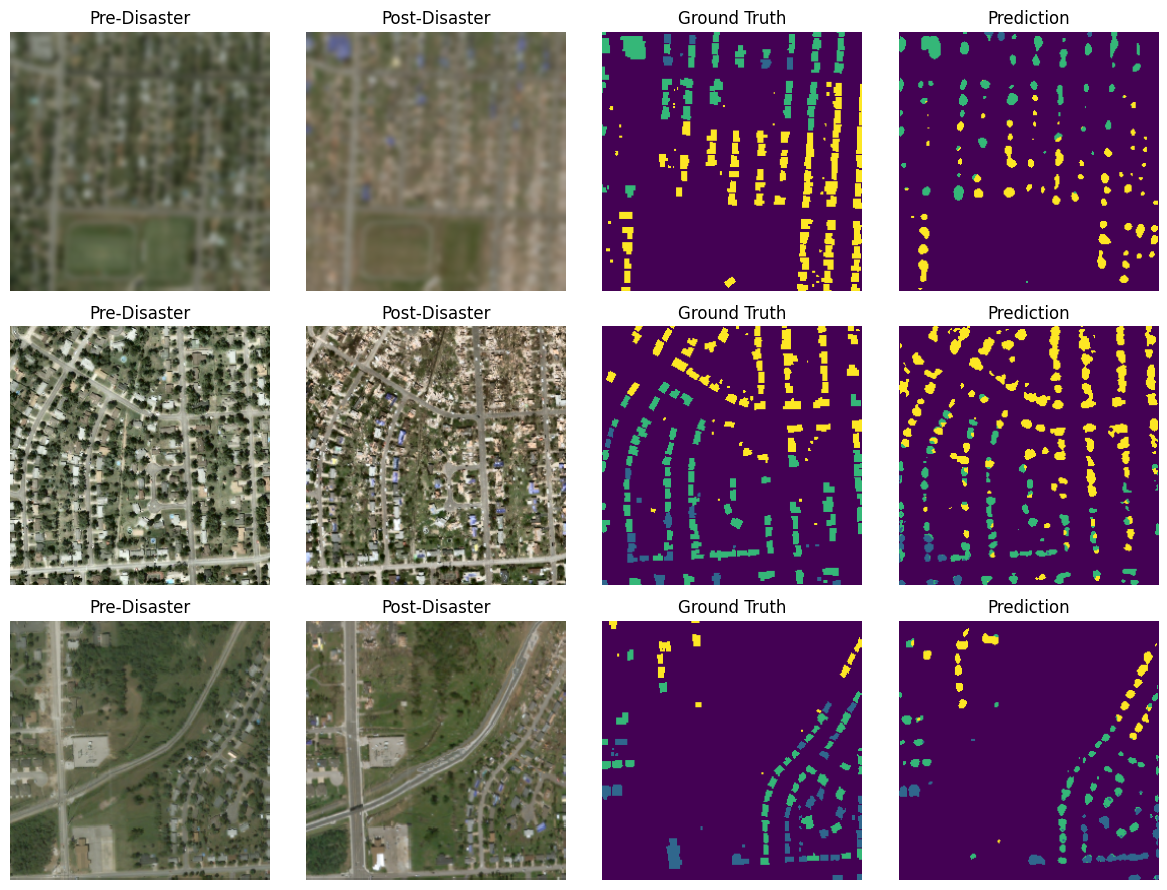

Streaming output truncated to the last 5000 lines.

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder don

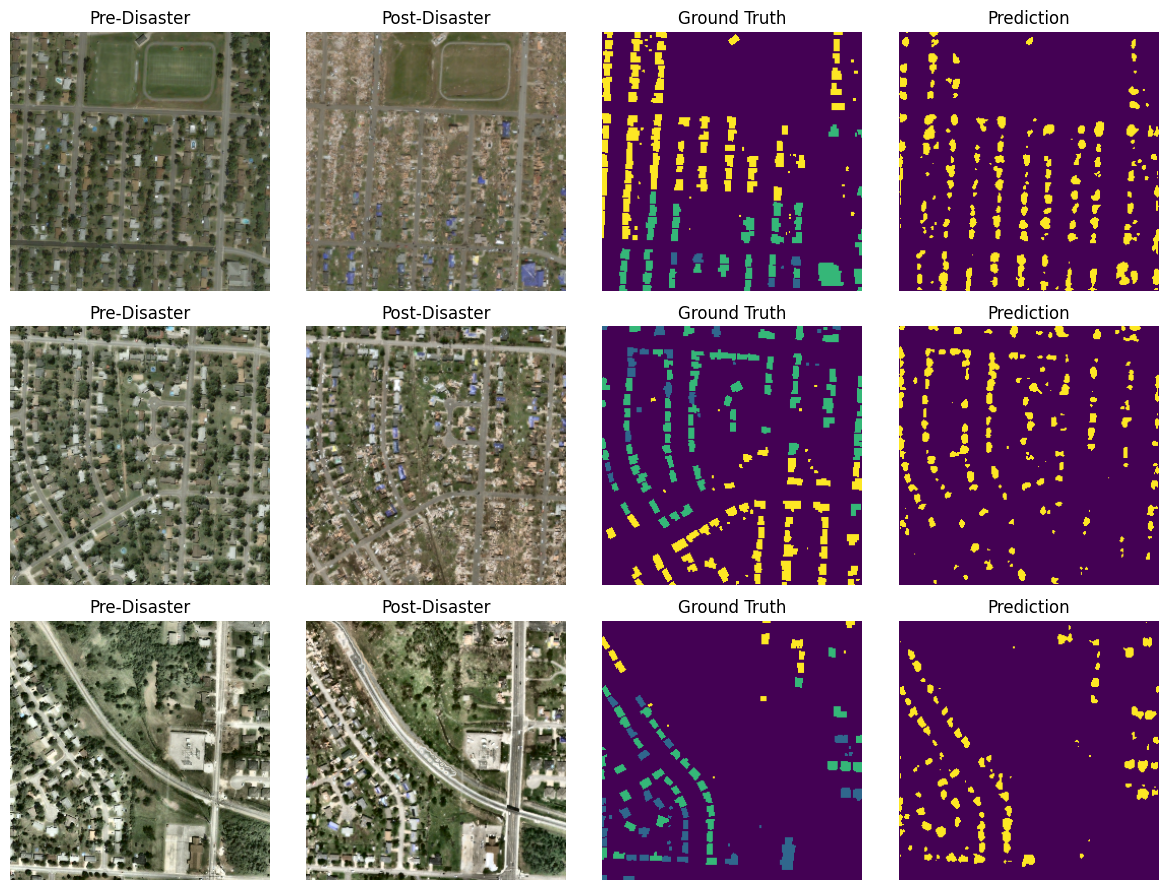

Streaming output truncated to the last 5000 lines.
Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done

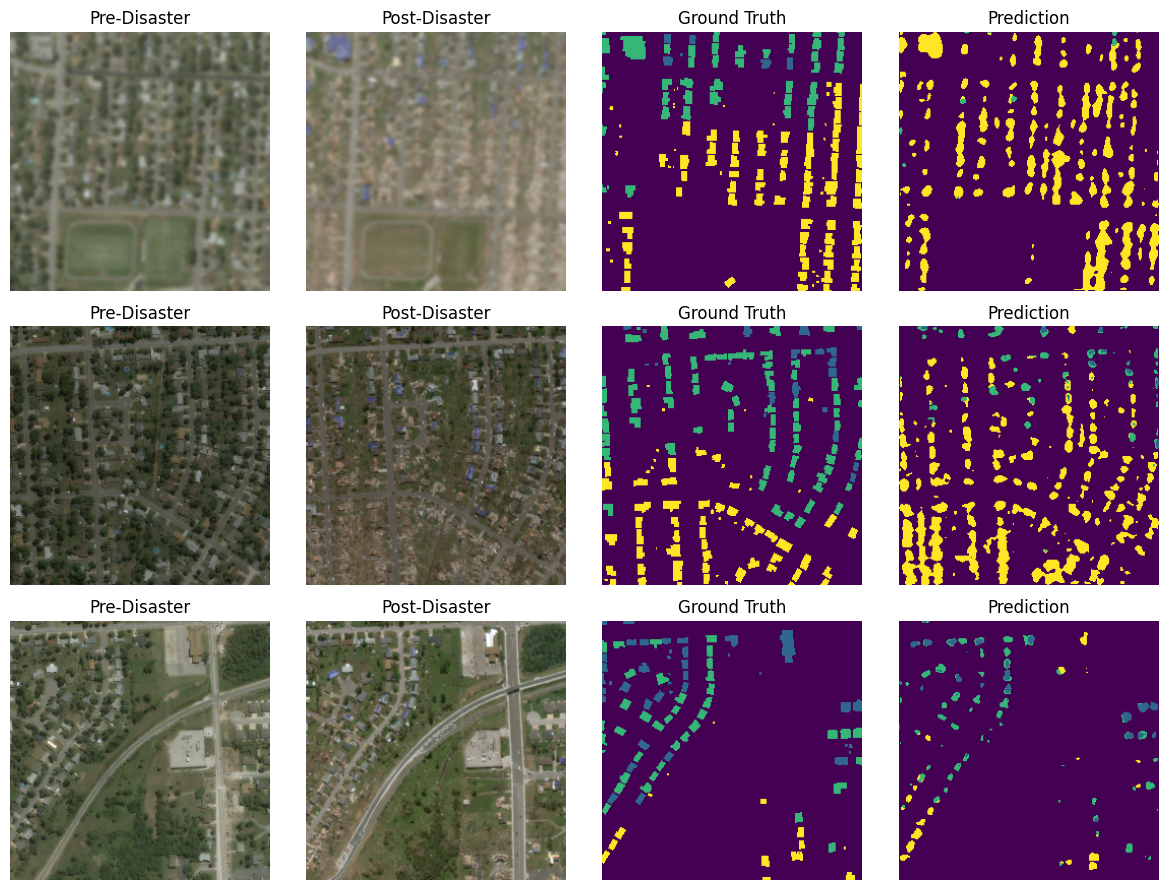

Streaming output truncated to the last 5000 lines.

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder don

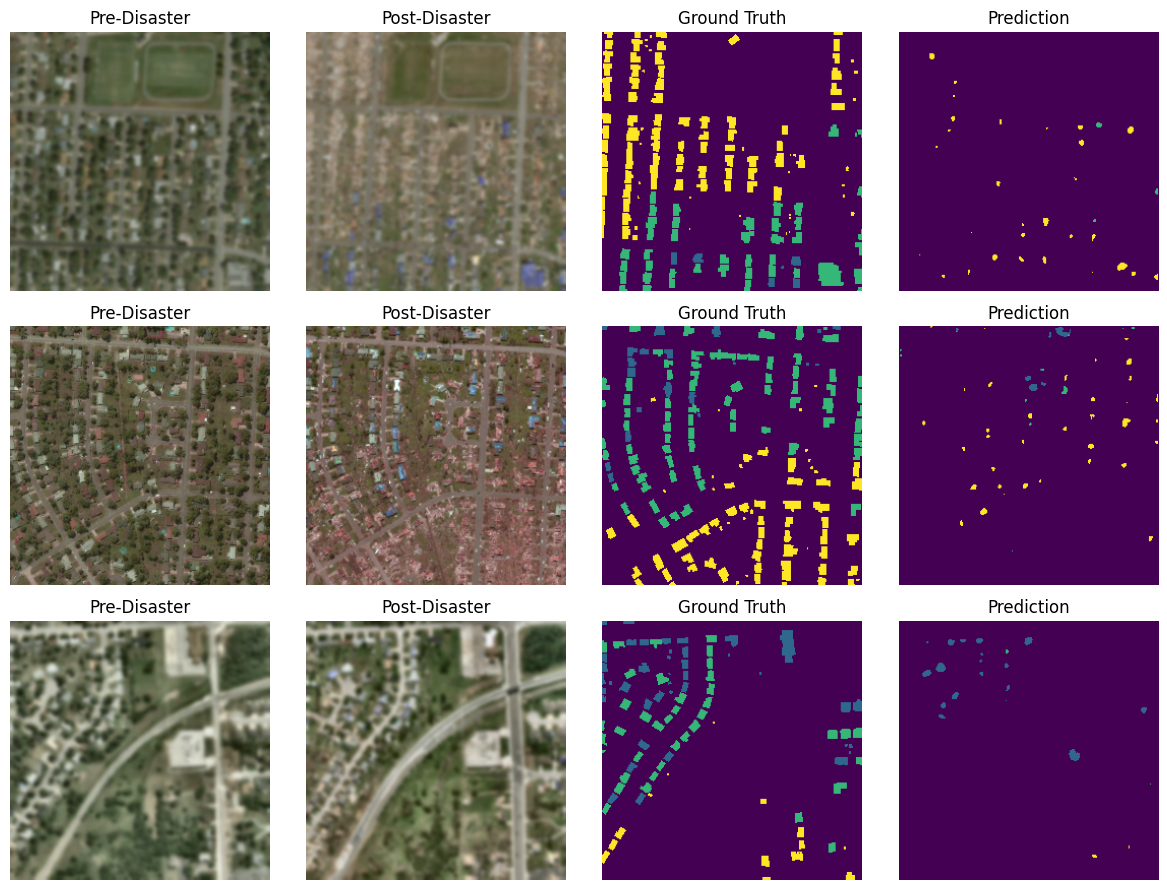

Streaming output truncated to the last 5000 lines.

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder don

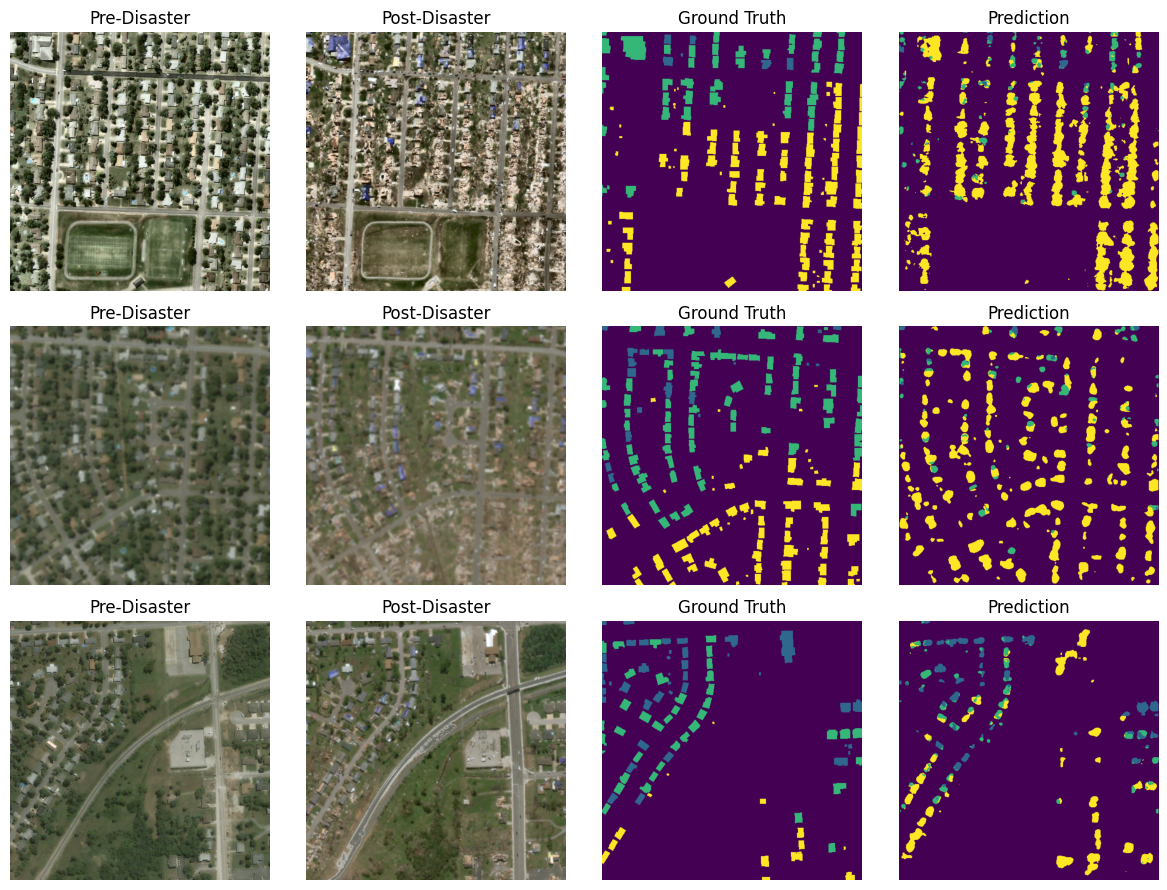

Streaming output truncated to the last 5000 lines.

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder done
Running fusion...

Running encoder...
Encoder don

In [ ]:
model = create_change_detection_model(config).to(device)
criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

progressive_train(
    model, dataset,
    device= device ,
    lr = 1e-3,
    save_path='disaster_model_best.pth'
)


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataset, device='cuda', num_samples=5, class_names=None):
    model.eval()
    plt.figure(figsize=(12, num_samples * 3))

    for idx in range(num_samples):
        pre, post, gt_mask = dataset[idx]

        # Move to device and add batch dimension
        pre_input = pre.unsqueeze(0).to(device)
        post_input = post.unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            preds = model(pre_input, post_input)
            if isinstance(preds, tuple):
                preds = preds[0]  # for deep supervision case

        pred_mask = torch.argmax(preds, dim=1).squeeze().cpu().numpy()  # shape: (H, W)
        gt_mask = gt_mask.cpu().numpy()  # shape: (H, W)

        # Convert tensors to numpy images
        pre_img = pre.permute(1, 2, 0).cpu().numpy()
        post_img = post.permute(1, 2, 0).cpu().numpy()

        # Undo normalization if needed
        pre_img = (pre_img * 0.5 + 0.5).clip(0, 1)
        post_img = (post_img * 0.5 + 0.5).clip(0, 1)

        # Plot
        plt.subplot(num_samples, 4, idx * 4 + 1)
        plt.imshow(pre_img)
        plt.title("Pre-Disaster")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 2)
        plt.imshow(post_img)
        plt.title("Post-Disaster")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 3)
        plt.imshow(gt_mask, cmap="viridis")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 4, idx * 4 + 4)
        plt.imshow(pred_mask, cmap="viridis")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import torch
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from typing import Optional
from torchvision.utils import save_image


CLASS_COLORS = {
    0: (0, 0, 0),
    1: (255, 255, 0),
    2: (255, 165, 0),
    3: (255, 0, 0),
}

def label_to_rgb(mask: np.ndarray) -> np.ndarray:
    """Converts (H, W) label mask to RGB (H, W, 3)"""
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASS_COLORS.items():
        rgb[mask == cls] = color
    return rgb




class ChangeDetectionTester:
    def __init__(self, model, dataset, device='cuda'):
        self.model = model.to(device)
        self.dataset = dataset
        self.device = device

    def test(self,
             save_dir: str,
             compute_metrics: bool = True,
             save_gif: bool = False,
             gif_path: Optional[str] = None,
             num_classes: int = 4):

        os.makedirs(save_dir, exist_ok=True)
        self.model.eval()

        miou_scores = []
        gif_frames = []

        for idx in tqdm(range(len(self.dataset)), desc="Testing"):
            pre, post, mask = self.dataset[idx]

            # Move input to device
            pre_input = pre.unsqueeze(0).to(self.device)
            post_input = post.unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model(pre_input, post_input)
                if isinstance(output, tuple):  # deep supervision
                    output = output[0]

            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            rgb_mask = label_to_rgb(pred_mask)

            # Save RGB prediction
            pred_save_path = os.path.join(save_dir, f"pred_{idx:03d}.png")
            save_image(torch.tensor(rgb_mask).permute(2, 0, 1) / 255.0, pred_save_path)

            # Append for GIF/timelapse
            if save_gif:
                gif_frames.append(Image.fromarray(rgb_mask))

            # Compute mIoU (if ground truth is available)
            if compute_metrics:
                gt_mask = mask.unsqueeze(0).to(self.device)
                miou = compute_iou(output, gt_mask, num_classes)
                miou_scores.append(miou)

        # Save GIF if requested
        if save_gif and gif_frames:
            gif_path = gif_path or os.path.join(save_dir, "timelapse.gif")
            gif_frames[0].save(gif_path, save_all=True, append_images=gif_frames[1:], duration=800, loop=0)
            print(f"✅ Saved GIF: {gif_path}")

        # Report final mIoU
        if compute_metrics and miou_scores:
            mean_miou = np.mean(miou_scores)
            print(f"✅ Final mIoU on test set: {mean_miou:.4f}")
            return mean_miou
        else:
            print("⚠️ No ground truth masks available — mIoU not computed.")
            return None


In [ ]:
# Initialize tester
tester = ChangeDetectionTester(model, dataset=test_dataset, device='cuda')

# Run full test pipeline
miou = tester.test(
    save_dir="predictions_test/",
    compute_metrics=True,
    save_gif=True
)
